# Features:

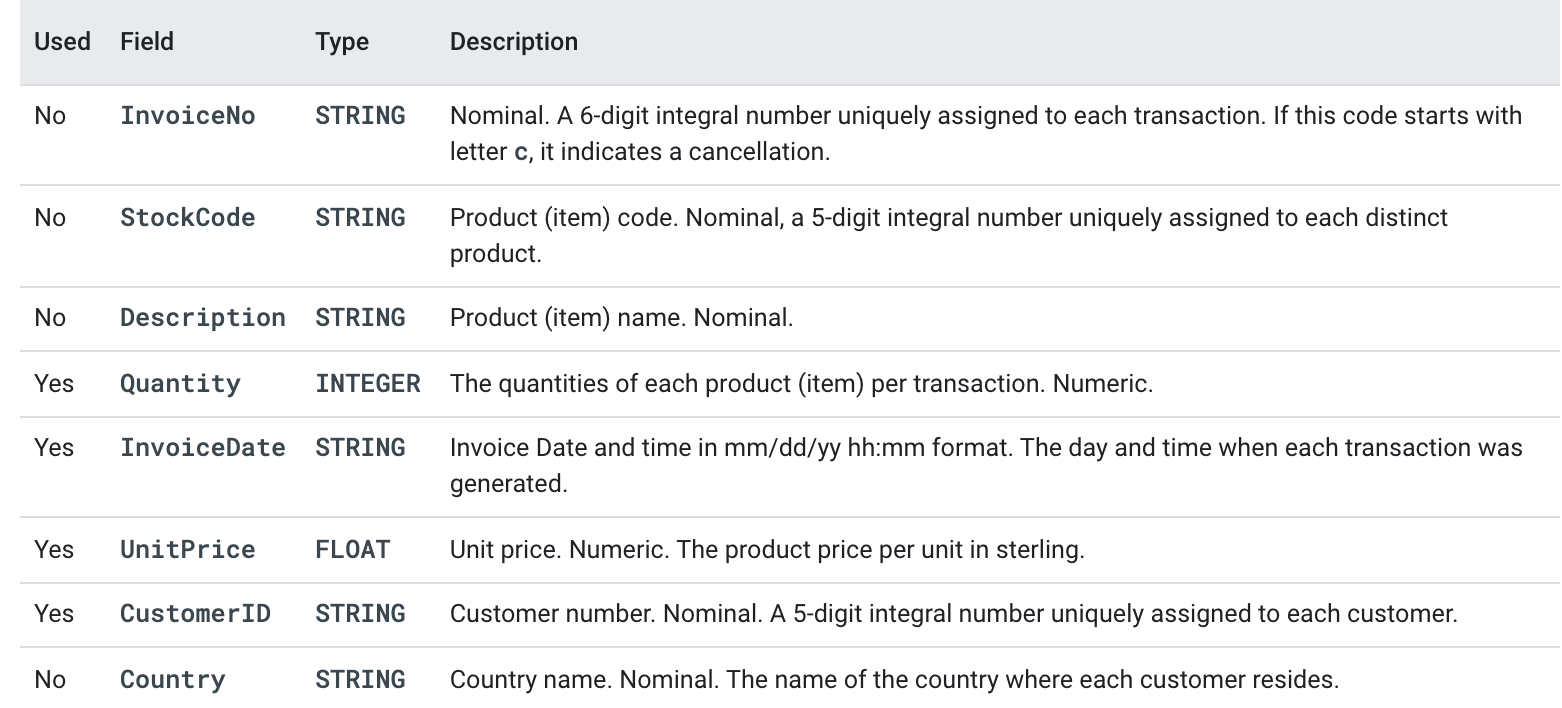


Cleaning the data

No matter which model you use, you must perform a set of preparation and cleaning steps that are common to all models. The following operations are required in order to get a set of workable fields and records:

Group the orders by day instead of using InvoiceNo, because the minimum time unit used by the probabilistic models in this solution is a day.

Keep only the fields that are useful for probabilistic models.

Keep only records that have positive order quantities and monetary values, such as purchases.

Keep only records with negative order quantities, such as returns.

Keep only records with a customer ID.

Keep only customers who bought something in the past 90 days.

Keep only customers who bought at least twice in the time period that's being used to create features.


In [25]:
import pandas as pd 

In [46]:
start_date = datetime.date(2011,3,1)
threshold_date = datetime.date(2011,9,1)

In [28]:
# df = pd.read_csv('raw_from_db.csv')
ss = df.drop_duplicates().groupby('CustomerID').Quantity.sum() 

In [44]:
df.loc[df.CustomerID.isin(ss.loc[ss <=0].index), 'Date'].unique()

array(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-06',
       '2010-12-08', '2010-12-09', '2010-12-14', '2010-12-15',
       '2010-12-16', '2010-12-20', '2011-01-06', '2011-01-10',
       '2011-01-11', '2011-01-18', '2011-01-31', '2011-02-01',
       '2011-02-11', '2011-02-22', '2011-02-23', '2011-07-20',
       '2011-03-15', '2011-03-17', '2011-04-20', '2011-05-05',
       '2011-05-06', '2011-05-11', '2011-05-12', '2011-05-19',
       '2011-06-01', '2011-06-16', '2011-07-18', '2011-07-19',
       '2011-07-28', '2011-09-15', '2011-09-16', '2011-09-19',
       '2011-09-22', '2011-09-29', '2011-10-04', '2011-10-06',
       '2011-10-07', '2011-10-10', '2011-10-12', '2011-10-14',
       '2011-10-17', '2011-10-20', '2011-10-21', '2011-10-24',
       '2011-11-09', '2011-11-15', '2011-11-22', '2011-12-02',
       '2011-12-05', '2011-12-08'], dtype=object)

In [82]:
import psycopg2

# connect to database
conn = None
conn = psycopg2.connect(
    host = 'localhost',
    database = 'OnlineRetail',
    user = 'postgres',
    password= '071212')

cur = conn.cursor()

In [ ]:
# Clean data 
# shreshold_date = '2011-09-01' 

sql_clean = '''
DROP TABLE IF EXISTS CLEANED_DATA;
CREATE TABLE CLEANED_DATA AS 
SELECT CUSTOMER_ID,
       ORDER_DATE,
       ORDER_VALUE,
       ORDER_QTY_ARTICLES
FROM ( 
SELECT * FROM
(SELECT CUSTOMERID AS CUSTOMER_ID,
INVOICEDATE AS ORDER_DATE,
ROUND(SUM(UNITPRICE * QUANTITY)::numeric,2) AS ORDER_VALUE,
SUM(QUANTITY) AS ORDER_QTY_ARTICLES
FROM RETAIL
GROUP BY CUSTOMER_ID,
ORDER_DATE) T
LEFT JOIN
(SELECT CUSTOMERID,
MAX(INVOICEDATE) AS LASTEST_ORDER
FROM RETAIL
GROUP BY CUSTOMERID) T1 ON T.CUSTOMER_ID = T1.CUSTOMERID
) A
INNER JOIN
(-- Only customers with more than one positive order values before threshold.
SELECT CUSTOMERID
FROM
(-- Customers and how many positive order values before threshold.
SELECT CUSTOMERID,
SUM(POSITIVE_VALUE) CNT_POSITIVE_VALUE
FROM
(-- Customer with whether order was positive or not at each date.
SELECT CUSTOMERID,
(CASE
 WHEN SUM(UNITPRICE * QUANTITY) > 0 THEN 1
 ELSE 0
END) POSITIVE_VALUE
FROM RETAIL
WHERE INVOICEDATE < CAST('2011-09-01' AS date)
GROUP BY CUSTOMERID,
INVOICEDATE) C
GROUP BY CUSTOMERID) D
WHERE CNT_POSITIVE_VALUE > 1) B ON A.CUSTOMER_ID = B.CUSTOMERID
WHERE -- keep only customers who bought something in the past 6 months
CAST('2011-12-09' AS date) - A.LASTEST_ORDER <= 180 -- Make sure returns are consistent.

AND ((ORDER_QTY_ARTICLES > 0
AND ORDER_VALUE > 0)
OR (ORDER_QTY_ARTICLES < 0
AND ORDER_VALUE < 0));
'''

In [92]:
# preparing featrues and target

sql_preparing = '''
--DROP TABLE IF EXISTS FEATURE_N_TARGET
--CREATE TABLE FEATURE_N_TARGET AS
SELECT TF.CUSTOMER_ID, --features_target
       TF.MONETARY_DNN,
       TF.MONETARY_BTYD,
       TF.CNT_ORDERS AS FREQUENCY_DNN,
       TF.CNT_ORDERS - 1 AS FREQUENCY_BTYD,
       TF.RECENCY,
       TF.T,
        ROUND(TF.RECENCY / CNT_ORDERS,2) AS TIME_BETWEEN,
        ROUND(TF.AVG_BASKET_VALUE,2) AS AVG_BASKET_VALUE,
        ROUND(TF.AVG_BASKET_SIZE::numeric,2) AS AVG_BASKET_SIZE,
        TF.CNT_RETURNS,
        (CASE
        WHEN TF.CNT_RETURNS > 0 THEN 1
        ELSE 0
        END) AS HAS_RETURNED, -- Used by BTYD mainly, potentially DNN if clipped improve results
         (CASE
        WHEN TF.CNT_ORDERS - 1 > 600 THEN 600
        ELSE TF.CNT_ORDERS - 1
        END) AS FREQUENCY_BTYD_CLIPPED,
        (CASE
        WHEN TF.MONETARY_BTYD > 100000 THEN 100000
        ELSE ROUND(TF.MONETARY_BTYD,2)
        END) AS MONETARY_BTYD_CLIPPED,
        (CASE
        WHEN TT.TARGET_MONETARY > 100000 THEN 100000
        ELSE ROUND(TT.TARGET_MONETARY,2)
        END) AS TARGET_MONETARY_CLIPPED, -- Target calculated for overall period
        ROUND(TT.TARGET_MONETARY,2) AS TARGET_MONETARY --features_target

FROM -- This SELECT uses only data before threshold to make features.

        (SELECT CUSTOMER_ID,
        SUM(ORDER_VALUE) AS MONETARY_DNN,
        (CASE
        WHEN COUNT(DISTINCT ORDER_DATE) = 1 THEN 0
        ELSE SUM(ORDER_VALUE_BTYD) / (COUNT(DISTINCT ORDER_DATE) -1)
        END) AS MONETARY_BTYD,
        MAX(ORDER_DATE) - MIN(ORDER_DATE) AS RECENCY,
        CAST('2011-09-01' AS date) - MIN(ORDER_DATE) AS T,
        COUNT(DISTINCT ORDER_DATE) AS CNT_ORDERS,
        AVG(ORDER_QTY_ARTICLES) AVG_BASKET_SIZE,
        AVG(ORDER_VALUE) AVG_BASKET_VALUE,
        SUM(CASE
        WHEN ORDER_VALUE < 1 THEN 1
        ELSE 0
        END) AS CNT_RETURNS
        FROM 

        (SELECT A.*,
        (CASE
        WHEN A.ORDER_DATE = C.ORDER_DATE_MIN THEN 0
        ELSE A.ORDER_VALUE
        END) AS ORDER_VALUE_BTYD 

        FROM CLEANED_DATA A 

        INNER JOIN
            (SELECT CUSTOMER_ID,
            MIN(ORDER_DATE) AS ORDER_DATE_MIN
            FROM CLEANED_DATA
            GROUP BY CUSTOMER_ID) C ON C.CUSTOMER_ID = A.CUSTOMER_ID) D
            WHERE --[START threshold_date]
             ORDER_DATE <= CAST('2011-09-01' AS date) --[END threshold_date]
            GROUP BY CUSTOMER_ID) TF, -- This SELECT uses all records to calculate the target (could also use data after threshold )
            (SELECT CUSTOMER_ID,
            SUM(ORDER_VALUE) TARGET_MONETARY
            FROM CLEANED_DATA --WHERE order_date > threshold_date

            GROUP BY CUSTOMER_ID) TT
        
WHERE TF.CUSTOMER_ID = TT.CUSTOMER_ID
        AND TF.MONETARY_DNN > 0
        AND TF.MONETARY_DNN <= 150000
        AND TF.MONETARY_BTYD > 0
    
'''



In [83]:
cur.execute(sql_clean)
cleaned_data=cur.fetchall()

In [93]:
cur.execute(sql_preparing)
features_n_target = cur.fetchall()

In [97]:
df_ft = pd.DataFrame(features_n_target,columns=['customer_id',
                                                'monetary_DNN','monetary_btyd',
                                                'frequency_DNN','frequency_btyd',
                                                'recency','t',
                                                'time_between',
                                                'avg_basket_value','avg_basket_size',
                                                'cnt_returns','has_returned',
                                                'frequency_btyd_clipped',
                                                'monetary_btyd_clipped',
                                                'target_monetary_clipped','target_monetary'])
df_ft.head()

,customer_id,monetary_DNN,monetary_btyd,frequency_DNN,frequency_btyd,frequency,t,time_between,avg_basket_value,avg_basket_size,cnt_returns,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary
0,12347,2790.86,519.7675000000000000,5,4,238,268,47.00,558.17,318.00,0,0,4,519.77,4310.00,4310.00
1,12348,1487.24,297.2200000000000000,3,2,110,259,36.00,495.75,708.00,0,0,2,297.22,1797.24,1797.24
2,12352,601.18,101.5600000000000000,4,3,34,197,8.00,150.30,47.00,0,0,3,101.56,1545.41,1545.41
3,12356,2753.08,481.4600000000000000,2,1,80,226,40.00,1376.54,793.00,0,0,1,481.46,2811.43,2811.43
4,12359,3459.93,970.8100000000000000,4,3,142,232,35.00,864.98,240.25,1,1,3,970.81,6245.53,6245.53


In [98]:
df_ft.to_csv('features_n_target.csv', index=False)